# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## Imports & load in data

In [1]:
import pandas as pd
import numpy as np
import math
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from time import time
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Exploratory Data Analysis 

### a. Offer portfolio data

The information given about the offers is that there are 3 different offer types:
- BOGO - buy one get one free
- Discount - discount with purchase
- Informational - provides information about products

It contains the attributes of 3 different offer types. While the duration was not explained I assumed from context that it is in terms of number of days.

In [2]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


The `channels` column consists of nested lists. 
The `difficulty` is in terms of dollars while the `duration` is in terms of days. 
-> Some feature scaling will need to be done.

In [3]:
#check for null values
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

Good news is that there are no missing values in this dataset

In [4]:
#check no. of unique offers
portfolio.id.nunique()

10

In [5]:
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

There are 10 unique offer ids we will have to take note of, with 4 each of bogo and discount types, while 2 informational types.

### b. Demographic data

The Demographic data for customers is provided in the `profile` dataset.

It is also relatively straightforward, as it contains the demographic profile on the customer.

In [6]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


We can see some null values in `gender` and `income`, while the `age` column contains some values that don't make sense (e.g. 118).

In [7]:
#check for null values
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

The `gender` and `income` have null values. Some good news is that whichever values are null in `gender` are also null in `income`. 

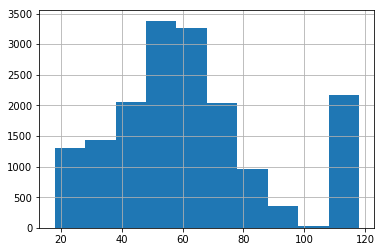

In [8]:
#check distribution of age column
profile.age.hist()

We can see above that the `age = 118` value does not make sense there as it is clearly out of the normal distribution.

In [9]:
#check count of age=118 value and corresponding gender and income columns
print(profile[profile['age']==118].count())
profile[['gender','income','age']][profile['age']==118].head()

age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64


,gender,income,age
0,None,NaN,118
2,None,NaN,118
4,None,NaN,118
6,None,NaN,118
7,None,NaN,118


The `age=118` column corresponds with the null `gender` and `income` columns.

-> We can actually drop them during preprocessing if they do not take too large a proportion of our data.

In [10]:
#check how many unique people are in dataset
profile['id'].nunique()

17000

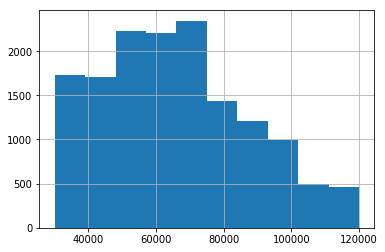

In [11]:
#check distributions of income
profile.income.hist()

The `became_member_on` column has some potential to be feature engineered to get the tenure of membership in days. 

-> This feature might have some influence on whether an offer is effective or not.

In [12]:
profile.became_member_on.head()

0    20170212
1    20170715
2    20180712
3    20170509
4    20170804
Name: became_member_on, dtype: int64

### c. Transactional records

The schema for the transactional data 

In [13]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [14]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

This data looks a bit more tricky, as it is ordered by time and has an event and value. 

-> The `value` column will have to be preprocessed depending on the event.

In [15]:
#check number of unique people represented
transcript['person'].nunique()

17000

It looks as though the number of people in transcript are the same as the number of people in the Demographics Data

In [16]:
#check for null values
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

There are no null values in this data.

In order to extract insights from the value column, I expand the values into individual columns depending on the event.

In [17]:
transcript=pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)
transcript.head()

,event,person,time,value,offer id,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


The `offer id` column ended up being duplicates so we have to clean it up further to ensure there is only one `offer id` column.

In [18]:
#create new column to ensure only one offer_id column
transcript['offer_id_new']=np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(),transcript['offer_id'],transcript['offer id'])

#drop unnecessary offer_id columns
transcript.drop(['offer id','offer_id'],axis=1,inplace=True)

#rename offer_id column
transcript.rename(columns={'offer_id_new':'offer_id'},inplace=True)

In [19]:
transcript.head()

,event,person,time,value,amount,reward,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


The additional transcript columns can be used for further exploration.

## Defining approach for preprocessing data for the model

I would clean and prepare the data for the models I intended to build.In order to identify the main drivers of an effective offer, I have to first define what an 'effective' offer is within the Starbucks app.

So first, I had to explore what kind of events are within each offer type.

In [20]:
#rename column
portfolio.rename(columns={'id':'offer_id'},inplace=True)

#join transcript with offer type
transcript=transcript.merge(portfolio,how='left',on='offer_id')

In [21]:
transcript.groupby(['event','offer_type'])['offer_type'].count()

event            offer_type   
offer completed  bogo             15669
                 discount         17910
offer received   bogo             30499
                 discount         30543
                 informational    15235
offer viewed     bogo             25449
                 discount         21445
                 informational    10831
Name: offer_type, dtype: int64

There are 4 types of events: `offer completed`, `offer received`, `offer viewed` and `transaction`.
But the data shows that we do not have any offer_id associated with `transactions`,


For a BOGO, the following events were recorded in the right sequence in time:

`offer received` -> `offer viewed` -> `transaction` -> `offer completed`

The `offer completed` event associated with it, I will have to define transactions as a conversion to effective offer:

`offer received` -> `offer viewed` -> `transaction`

## Data Preprocessing

### a. Process Offer ids to transactions

After defining the approach above, we now have to explore methods to assign offer_ids to specific transactions. 

In [22]:
#define dropcolumns function as I will be doing this many times
def drop_cols(drop_cols,df,inplace=False):
    '''
    inputs:
    - drop_cols: list or string of column name
    - df: dataframe from which column should
    - inplace: specify whether columns
    
    outputs:
    - Returns dataframe with dropped columns.
       
    '''
    df=df.drop(columns=drop_cols,axis=1,inplace=inplace)
    return df

In [23]:
#drop unnecessary columns to clean dataset
transcript=drop_cols(['reward_x','reward_y'],transcript)
#sort events by person and time
transcript=transcript.sort_values(['person','time'])

In [24]:
#filter dataset for transactions that occur after an offer is viewed, forward fill offer ids by person
offers_view_transacted=transcript[['time','offer_id','person','event']][(transcript['event']=='transaction') | (transcript['event']=='offer viewed')].groupby(['person','offer_id']).ffill()
offers_view_transacted['offer_id']=offers_view_transacted['offer_id'].ffill()

The dataset is just a subset of the `transcript` dataset, I can create a new dataset with the filled in offer ids for transactions.

In [25]:
transcript=transcript.merge(offers_view_transacted,how='left',on=['person','time','event'])

In [26]:
#clean up dataset to unify multiple offer_id columns into one column
transcript['offer_id']=np.where(transcript['offer_id_x'].isnull(),transcript['offer_id_y'],transcript['offer_id_x'])

drop_cols(['offer_id_x','offer_id_y'],transcript,inplace=True);

In [27]:
#merge portfolio dataset again to get offer data for the transaction events
transcript=transcript.merge(portfolio,how='left',on='offer_id')
transcript['duration']=np.where(transcript['duration_x'].isnull(),transcript['duration_y'],transcript['duration_x'])
drop_cols(['duration_x','offer_type_x','difficulty_x','channels_x','duration_y'],transcript,inplace=True);
transcript.rename(columns={'channels_y':'channels','reward_y':'reward','difficulty_y':'difficulty','offer_type_y':'offer_type'},inplace=True)

In [28]:
transcript.head()

,event,person,time,value,amount,offer_id,channels,difficulty,offer_type,reward,duration
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0


### b. Flagging transactions and offers completed after offers viewed

The data for modeling and analysis is to identify a completed offer and transactions occurring after an offer is viewed. 

The events `offer viewed`,`transaction`, and `offer completed` occur in the same event space and are in the corrrect sequence of time, we can be assured that it is a transaction and/or completed offer occurring only after an offer is viewed. 

-> I created a new column to flag the previous offer id using pandas' `shift` function.

In [29]:
#get sample space of events consisting of offer viewed, transactions and offer completed
offers_viewed_transactions_completed=transcript[(transcript['event']=='offer viewed') | (transcript['event']=='transaction') | (transcript['event']=='offer completed')].copy()

In [30]:
#add extra column to flag the previous offer id
offers_viewed_transactions_completed['offer_id_previous'] = offers_viewed_transactions_completed.groupby(['person','offer_id'])['offer_id'].shift()

In [31]:
#flag a completed transaction/offer completed as long as the previous offer id consists of events in the same sample space
offers_viewed_transactions_completed['valid_completed']=np.where(offers_viewed_transactions_completed['offer_id_previous']==offers_viewed_transactions_completed['offer_id'],1,0)

The dataset `offers_viewed_transactions_completed` consists of all other possible events

So we need to do is to append the all `offers received` events in the `transactions_clean` dataset to ensure we have our complete dataset again.

In [32]:
#get only offer received events
offers_received=transcript[transcript['event']=='offer received'].copy()

#ensure all columns are the same between datasets to be appended
offers_received['offer_id_previous']=np.nan
offers_received['valid_completed']=np.nan

#append datasets to complete dataset of transactions
transcript=offers_received.append(offers_viewed_transactions_completed)

#sort values
transcript=transcript.sort_values(['person','time'])

Having assigned offer_ids for transactions for which an `offer viewed` event occurred prior

In [33]:
#define function to split into 3 offer types
def split(offer_type,grp_df):
    '''
    Splits dataframe
    
    inputs: offer_type, grp_df
    
    outputs:
    - Returns dataframe containing data of just offer type.
       
    '''
    df=grp_df[grp_df['offer_type']==offer_type].copy()
    return df

In [34]:
# Split transcript into 3 different offer types
transcript_bogo=split('bogo',transcript)
transcript_discount=split('discount',transcript)
transcript_info=split('informational',transcript)

For BOGO and discount offers, we will only consider `offer completed` events as the conversion events

In [35]:
# Define function for repeated operation
def grp1(df):
    '''    
    inputs:
    - df: original transcript dataframe 

    outputs:
    - Returns dataframe containing transcript data of just group 1 users.
       
    '''
    grp1=df[['person','offer_id']][(df['valid_completed']==1) & (df['event']=='offer completed')] \
         .groupby(['person','offer_id']).count().reset_index()
    return grp1

In [36]:
grp1_bogo=grp1(transcript_bogo)
grp1_discount=grp1(transcript_discount)

The informational offers we will define group 1 later as there is an additional consideration we need to take into account for transactions

In [37]:
# Define a function to repeat this for 2 datasets - BOGO & discount
def no_conv(df):
    
    '''
    Takes in transcript dataframe
    
    inputs:
    - df: original transcript dataframe of specific offer type 
    
    outputs:
    - Returns dataframe containing unqiue person-offer_id
           
    '''
    
    # The subset offer ids that have transactions or conversions by person and offer_id
    conversion_ids=df[['person','offer_id']][(df['event']=='transaction') | (df['event']=='offer completed') ] \
                   .groupby(['person','offer_id']).count().reset_index()

    # Check for unique person-offer_id
    offers_received_only=df[['person','offer_id']][df['event']=='offer received'] \
                         .groupby(['person','offer_id']).count().reset_index()

    # Create merged dataset
    check_merge=conversion_ids.merge(offers_received_only,how='right',on=['person','offer_id'],indicator=True)
    
    return check_merge

In [38]:
#check how many are in either group
check_merge_bogo=no_conv(transcript_bogo)
check_merge_discount=no_conv(transcript_discount)

There are definitely a fair number of unique person-offer_id pairs that have `offer received` events, but no conversion events. These would be considered offers in group 2 and 4 within each offer type, according to our definition above. 


In [39]:
# define group 2 & 4 function as will repeat this for BOGO and discount offers
def grp_2_4(df):
    
    '''
    Takes in output dataframe
    
    inputs:
    - df: output dataframe from no_conv function
    
    outputs:
    - Returns 2 dataframes containing unique person-offer_id pairs with dataframe
       
    '''
    
    # The subset to check group 2 and 4
    grp_2_4=df[df['_merge']=='right_only']

    # Remerge with transcript
    grp_2_4=grp_2_4.merge(transcript,how='left',on=['person','offer_id'])

    # Separate people with offer viewed event, and people with offer received but no offer viewed
    grp2=grp_2_4[['person','offer_id']][grp_2_4['event']=='offer viewed'].groupby(['person','offer_id']).count().reset_index()
    
    # Remerge with full dataset
    drop_cols('_merge',grp_2_4,inplace=True)
    grp4=grp_2_4.merge(grp2[['person','offer_id']],how='left',indicator=True)
    
    # Get remaining to get grp4
    grp4=grp4[grp4['_merge']=='left_only'].copy()
    
    return grp2,grp4

In [40]:
grp2_bogo,grp4_bogo=grp_2_4(check_merge_bogo)
grp2_discount,grp4_discount=grp_2_4(check_merge_discount)

For BOGO and discount offers, they would be people with `offer completed` events that have `valid_completed != 1`.

In [41]:
def grp3(df):
    '''
    Takes in transcript dataframe
    
    inputs:
    - df: original transcript dataframe of specific offer type 
    
    outputs:
    - Returns dataframe containing unqiue person-offer_id pairs with conversion events and offers
       
    '''
    
    # Check all conversion events with invalid conversions
    grp3=df[['person','offer_id']][(df['event']=='offer completed') & (df['valid_completed']!=1)] \
         .groupby(['person','offer_id']).count().reset_index()
    
    return grp3

In [42]:
grp3_bogo=grp3(transcript_bogo)
grp3_discount=grp3(transcript_discount)

We have split our data into 4 different customer groups for the BOGO and discount offers. 

In [43]:
def offers(grp1,grp2):
    '''
    inputs:
    - grp1: dataframe containing group1 customer data 
    - grp2: dataframe containing group2 customer data
    
    outputs:
    - Returns dataframe with labeled effective offer column
    '''
    #assign effective offer flag column
    grp1['effective_offer']=1
    grp2['effective_offer']=0

    #append datasets together
    offers=grp1.append(grp2,sort=False)
    return offers

In [44]:
offers_bogo=offers(grp1_bogo,grp2_bogo)
offers_discount=offers(grp1_discount,grp2_discount)

We have successfully prepared the target variables for our BOGO and discount datasets. 

### c. Considering duration/validity of offers in converted transactions from informational offers

There is an additional rule to consider when considering an effective/converted transaction and offer.

In [45]:
#convert time into days
transcript_info['day_offer']=transcript_info['time']/24
#drop unnecessary columns
drop_cols(['time','value','offer_id_previous'],transcript_info,inplace=True);

In [46]:
#sort transactions to ensure all events occurring by person and offer
transcript_info=transcript_info.sort_values(['person','day_offer','event','offer_id'])

We can get the difference between two events using the `diff` function in pandas.

In [47]:
#get difference in time for informational offers
transcript_info['diff_info']=transcript_info[(transcript_info['offer_type']=='informational') & ((transcript_info['event']=='offer received') | (transcript_info['event']=='transaction'))].groupby(['person','offer_id'])['day_offer'].diff()

In [48]:
#create column for flagging valid events
transcript_info['valid_completed_duration']=np.nan

#flag valid events if within duration
transcript_info.loc[transcript_info['diff_info']<=transcript_info['duration'],'valid_completed_duration']=1

#fill any missing values with 0 flag
transcript_info['valid_completed_duration']=transcript_info['valid_completed_duration'].fillna(value=0)

We have 4 possible scenarios for an informational offer within the `transcript_info` dataset:

|No.| valid_completed | valid_completed_duration | Scenario |
|---| --- | --- | --- |
|1| 1 | 0 | completed transaction after offer viewed event, but not within duration |
|2| 0/null | 1 | completed transaction within duration, but with no offer viewed event prior |
|3| 1 | 1 | completed transaction within duration, with offer viewed event - **an effective offer** |
|4| 0//null | 0 | did not complete transaction within duration, no offer viewed event prior |


We will need to separate those users in group 2 - those who may have received and viewed an offer

In [49]:
#flag effective_offers where valid_completed=1 and valid_completed_duration=1
transcript_info['effective_offer']=np.where(((transcript_info['valid_completed']==1) & (transcript_info['valid_completed_duration']==1)),1,0)

We can subset them into the 4 groups already outlined above. 

In [50]:
#separate group 1 in transcript_into
grp1_info=transcript_info[['person','offer_id']][transcript_info['effective_offer']==1].groupby(['person','offer_id']).sum().reset_index()

Using similar steps to what we did with BOGO and Discount offers, since we don't have the duration consideration.

In [51]:
#separate out group 2 of customers
check_merge_info=no_conv(transcript_info)
print('For informational offers:')
print(check_merge_info.groupby(['_merge']).count())

For informational offers:
            person  offer_id
_merge                      
left_only        0         0
right_only    5412      5412
both          7239      7239


In [52]:
grp2_info,grp4_info=grp_2_4(check_merge_info)

For group 3, we have to consider those with conversions who do not have an offer viewed prior

In [53]:
# The scenario 1
grp3_1=transcript_info[['person','offer_id']][(transcript_info['event']=='transaction')&(transcript_info['valid_completed']!=1) & (transcript_info['valid_completed_duration']==1)].groupby(['person','offer_id']).count().reset_index()

# The scenario 2
grp3_2=transcript_info[['person','offer_id']][(transcript_info['event']=='transaction')&(transcript_info['valid_completed']==1) & (transcript_info['valid_completed_duration']!=1)].groupby(['person','offer_id']).count().reset_index()
grp3_info=grp3_1.append(grp3_2,sort=False)
del grp3_1
del grp3_2

We can append the datasets together to make the offers_info dataset, ready for modeling.

In [54]:
offers_info=offers(grp1_info,grp2_info)

-> Now that we have subset all our datasets into effective and ineffective offers depending on offer type.

### d. Feature engineering

We have to look back had to look into the features and see how to be creative in creating new features.

#### d.1. `became_member_on` column to be engineered

In [55]:
#rename column for merging
profile.rename(columns={'id':'person'},inplace=True)

# The function to reuse for 3 datasets
def member(df):
    '''
    inputs:
    - df: original dataframe to transform became_member_on column  
    
    outputs:
    - Returns dataframe with became_member_on column transformed to be tenure in days
    
    '''
    #merge to get user demographic profile
    df=df.merge(profile,how='left',on='person')
    
    # Convert the features into member tenure
    df['year']=pd.Series([int(str(x)[:4]) for x in df['became_member_on']])
    df['month']=pd.Series([int(str(x)[-3]) for x in df['became_member_on']])
    df['day']=pd.Series([int(str(x)[-2:]) for x in df['became_member_on']])
    
    df=drop_cols('became_member_on',df)
    df.loc[df['year'] == 2018, 'membership_tenure_days'] = (30*df['month'])+df['day']
    df.loc[df['year'] != 2018, 'membership_tenure_days'] = ((2018-df['year'])*365)+(30*df['month'])+df['day']
    df=drop_cols(['year','month','day'],df)
    
    return df

In [56]:
# see how to be creative in creating new features.
offers_bogo=member(offers_bogo)
offers_discount=member(offers_discount)
offers_info=member(offers_info)

#### d.2. Count of offers received
As part of some further data exploration, I discovered that there could be multiple offers received per person.

person
0009655768c64bdeb2e877511632db8f    5
00116118485d4dfda04fdbaba9a87b5c    2
0011e0d4e6b944f998e987f904e8c1e5    5
0020c2b971eb4e9188eac86d93036a77    5
0020ccbbb6d84e358d3414a3ff76cffd    4
Name: event, dtype: int64


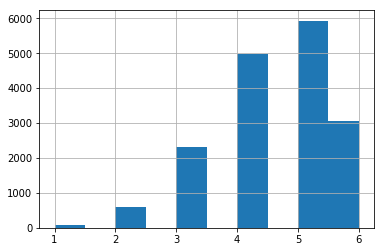

In [57]:
#group event=offer received per person in transactional records
print(transcript[transcript['event']=='offer received'].groupby('person')['event'].count().head())

#visualise offers received per person
transcript[transcript['event']=='offer received'].groupby('person')['event'].count().hist()

The offer received per person in the transactional data could range from 1 to 6 offers received.

In [58]:
#get count of offers received per person, put into separate dataset
df_offer_received_cnt=transcript[transcript['event']=='offer received'].groupby(['person','offer_id','time']).count()['event'].reset_index()

#rename columns
df_offer_received_cnt.rename(columns={'event':'offer_received_cnt'},inplace=True)

#drop unnecessary columns
drop_cols('time',df_offer_received_cnt,inplace=True)

#ensure only unique person-offer_id pairs
df_offer_received_cnt=df_offer_received_cnt.groupby(['person','offer_id']).sum().reset_index()

#### d.2. Separating user behaviours by transactions

These would be the sum of transactions done by people not in group 1. The objective of offers are to drive purchases, so it would already be the case that users with high spend in their transactions would be flagged as `effective_offers`. 

We have already defined that there are people in groups 3 and 4, where they are separate pools of users who are loyal spenders, and already tend to purchase more, isolated from the the effect of offers. 

In [59]:
#filter dataset by invalid transactions
df_transactions_invalid=transcript[(transcript['event']=='transaction') & (transcript['valid_completed']==0)].groupby(['person','offer_id'])['amount'].sum().reset_index()
df_transactions_invalid.rename(columns={'amount':'amount_invalid'},inplace=True)

#### d.3. Time elapsed between offers received

There might be some predictive power in the time elapsed between offers received. 

In [60]:
#convert time into days
transcript['day_offer']=transcript['time']/24
#drop unnecessary columns
drop_cols(['time'],transcript,inplace=True);

#find time elapsed between offers received
transcript['time_elapsed_offers']=transcript[transcript['event']=='offer received'].groupby(['person','offer_id'])['day_offer'].diff()

#fill missing values with 0, as if someone does not receive an offer or is receiving an offer for the first time, there is no time elapsed
transcript['time_elapsed_offers']=transcript['time_elapsed_offers'].fillna(value=0)

#create temporary dataset
df_time_elapsed=transcript.groupby(['person','offer_id'])['time_elapsed_offers'].sum().reset_index()

### f. Preparing data for implementation

We can finally begin with preparing the data for modeling. 

#### f.1.a. Merge with temporary datasets created above to include engineered features

In [61]:
#merge to get offers received count and invalid amount transacted 
offers_bogo=offers_bogo.merge(df_offer_received_cnt[['person','offer_id','offer_received_cnt']],how='left',on=['person','offer_id'])
offers_bogo=offers_bogo.merge(df_transactions_invalid[['person','offer_id','amount_invalid']],how='left',on=['person','offer_id'])

#### f.1.b. Drop missing values in gender column for demographic data

Checking whether dropping the missing values will result in a significant loss in data.

In [62]:
#check % of missing values in dataset
(offers_bogo.isnull().sum()/len(offers_bogo)*100).sort_values(ascending=False).head()

amount_invalid            96.323752
income                     7.057489
gender                     7.057489
offer_received_cnt         0.000000
membership_tenure_days     0.000000
dtype: float64

The missing values are quite extensive especially for the `amount_invalid` column. It is debatable whether this column `amount_invalid` would be useful to include in the model. Since it is so 'sparse' for BOGO offers, it might not have much information after all.

In [63]:
#fill missing values for amount_invalid with 0
offers_bogo['amount_invalid']=offers_bogo['amount_invalid'].fillna(value=0)

#drop income and gender null rows
offers_bogo.dropna(inplace=True);

#### f.1.c. Separate the channel column into categorical variables

In [64]:
#foresee need to reuse function so create rename function
def rename(col_name,df):
    df[col_name]=np.where(df[col_name]==col_name,1,0)
    return df

#foresee need to reuse dummy variable encoding function
def dummy(df,col):
    df=pd.concat([df[:],pd.get_dummies(df[col],prefix=col)],axis=1)
    df=drop_cols(col,df)
    return df

In [65]:
#merge with portfolio to get offer details
offers_bogo=offers_bogo.merge(portfolio,how='left',on='offer_id')

#convert channels into categorical variables
channels = offers_bogo['channels'].apply(pd.Series)
channels = channels.rename(columns={0:'web',1:'email',2:'mobile',3:'social'})
offers_bogo=pd.concat([offers_bogo[:], channels[:]], axis=1)
rename('web',offers_bogo)
rename('email',offers_bogo)
rename('mobile',offers_bogo)
rename('social',offers_bogo)
offers_bogo=drop_cols('channels',offers_bogo)

#convert gender into categorical variables
offers_bogo=dummy(offers_bogo,'gender')

We need to repeat these steps for `offers_discount`, I created a function containing all the steps above.

In [66]:
def prep_offers_df(df):
    
    '''
    inputs:
    - df: original dataframe
    
    outputs:
    - Returns dataframe containing engineered features
    
    '''
    # Merge to get engineered features 
    df=df.merge(df_offer_received_cnt[['person','offer_id','offer_received_cnt']],how='left',on=['person','offer_id'])
    df=df.merge(df_transactions_invalid[['person','offer_id','amount_invalid']],how='left',on=['person','offer_id'])
    
    # Cleaning data to convert 
    df['amount_invalid']=df['amount_invalid'].fillna(value=0)
    df.dropna(inplace=True);
    df=df.merge(portfolio,how='left',on='offer_id')

    # Convert channels into categorical variables
    channels = df['channels'].apply(pd.Series)
    channels = channels.rename(columns={0:'web',1:'email',2:'mobile',3:'social'})
    df=pd.concat([df[:], channels[:]], axis=1)
    rename('web',df)
    rename('email',df)
    rename('mobile',df)
    rename('social',df)
    df=drop_cols('channels',df)
    
    # convert gender column into dummy variables
    df=dummy(df,'gender')

    return df

In [67]:
#prepare data for offer_discounts
offers_discount=prep_offers_df(offers_discount)

For `offers_info` dataset, a slightly different treatment needs to be done as the `channels` column contains a different order of values.

In [68]:
#merge with portfolio to get offer details
offers_info=offers_info.merge(portfolio,how='left',on='offer_id')

#reset index for offers_info
offers_info=drop_cols('index',offers_info.reset_index())

In [69]:
#expand channel column into categorical variables
def channel_col(name,df=offers_info):
    '''
    inputs:
    - name: name of channel column to be transformed 
    - df: dataframe 
    
    outputs:
    - offer_info dataframe with channel column transformed
    
    '''
    df[name]= np.nan
    df.loc[pd.Series([name in df['channels'][x] for x in range(len(df['channels']))]),name]=1
    df[name]=df[name].fillna(value=0)
    return df

In [70]:
channel_col('web')
channel_col('email')
channel_col('mobile')
channel_col('social');

drop_cols('channels',offers_info,inplace=True);

In [71]:
# Repurpose function for offers_info
def prep_offers_df(df):
    '''
    inputs:
    - df: dataframe
    
    outputs:
    - Returns dataframe with engineered features and filled missing values
       
    '''
    #merge to get engineered features 
    df=df.merge(df_offer_received_cnt[['person','offer_id','offer_received_cnt']],how='left',on=['person','offer_id'])
    df=df.merge(df_transactions_invalid[['person','offer_id','amount_invalid']],how='left',on=['person','offer_id'])

    # Cleaning data to convert
    df['amount_invalid']=df['amount_invalid'].fillna(value=0)
    df.dropna(inplace=True);
    
    #convert gender column into dummy variables
    df=dummy(df,'gender')
    return df

In [72]:
offers_info=prep_offers_df(offers_info)

In [73]:
offers_info.head()

,person,offer_id,effective_offer,age,income,membership_tenure_days,difficulty,duration,offer_type,reward,web,email,mobile,social,offer_received_cnt,amount_invalid,gender_F,gender_M,gender_O
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,33,72000.0,506.0,0,4,informational,0,1.0,1.0,1.0,0.0,1.0,0.00,0,1,0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,33,72000.0,506.0,0,3,informational,0,0.0,1.0,1.0,1.0,1.0,0.00,0,1,0
2,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,1,59,90000.0,824.0,0,3,informational,0,0.0,1.0,1.0,1.0,1.0,0.00,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,1,24,60000.0,771.0,0,3,informational,0,0.0,1.0,1.0,1.0,1.0,16.27,1,0,0
4,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed,1,26,73000.0,566.0,0,4,informational,0,1.0,1.0,1.0,0.0,1.0,0.00,1,0,0


#### f.2. Treatment of duplicate records

The data cleanly according to unique person-offer_id pairs by group, we should not have any duplicate records.

In [74]:
#check multiple records for each person and offer ids for the target variable
print((offers_bogo.groupby(['person','offer_id','effective_offer']).size()>1).sum())
print((offers_discount.groupby(['person','offer_id','effective_offer']).size()>1).sum())
print((offers_info.groupby(['person','offer_id','effective_offer']).size()>1).sum())

0
0
0


## Implementation

Currently, the datasets are ready, we can proceed to implementing the model. Revisiting our objective, we wanted to analyse the drivers of an effective offer, with the target variable being `effective_offer`.

I also selected random forest as an alternate model to compare the baseline model is as an improvement over simple ensemble bagging of decision trees, in order to drive towards a high accuracy in training the model. 

-> We have to make sure that the classes we are predicting for are balanced in each dataset.

In [75]:
#check for class balance in datasets
print(offers_bogo[['person','effective_offer']].groupby('effective_offer').count()/len(offers_bogo))
print(offers_discount[['person','effective_offer']].groupby('effective_offer').count()/len(offers_discount))
print((offers_info[['person','effective_offer']].groupby('effective_offer').count()/len(offers_info)))

                  person
effective_offer         
0                0.17783
1                0.82217
                   person
effective_offer          
0                0.135256
1                0.864744
                 person
effective_offer        
0                0.2611
1                0.7389


The classes are quite uneven for all three offer types, but not too imbalanced such that it would pose a problem.

A note on model evaluation and validation; since the classes for the all 3 models are imbalanced, I decided to implement both accuracy and f1 score as the model evaluation metric. 

### a. Model Implementation

Now, we are creating 3 models to predict the effectiveness of an offer within each type, depending on offer attributes and user demographics.

So first, define our target and features variables.

In [76]:
def data_prep(df,drop_cols_prep):
    '''
    inputs:
    - df: prepared dataframe
    
    outputs:
    - Returns 2 dataframes
    '''
    # Split the data into features and target label
    target = df['effective_offer']
    features = drop_cols(drop_cols_prep,df)
    return features,target

Next, I split the data into training and test sets. Since the features of my data are all on different scales

In [77]:
#prepare model pipeline
def model_pipeline(features,target):
    '''
    inputs:
    - features and target dataframe 
    
    outputs:
    - Outputs X_train, X_test, y_train and y_test dataframes
    '''
    
    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features,target, test_size=0.20, random_state=42)

    # Fit and transform scaling on training data
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)

    # Scale for testing data
    X_test=scaler.transform(X_test)
    
    return X_train,X_test,y_train, y_test

Defining the functions here to run my model as I plan to implement 3 different models;

In [78]:
def train_predict(learner, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - X_train: training set
       - y_train: evaluate the scores rating for the training set
       - X_test: testing set
       - y_test:evaluate the scores rating for the testing set
    
    outputs: The result for the Mean Squared Error and Accuracy Scores
    
    '''
    results = {}
    
    #Fit the learner to the training data and get training time
    start = time() 
    learner = learner.fit(X_train, y_train)
    end = time() 
    results['train_time'] = end-start
    
    # Get predictions on the test set(X_test), then get predictions on first 300 training samples
    start = time() 
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() 
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
    results['training_score']=learner.score(X_train,y_train)
    results['testing_score']=learner.score(X_test,y_test)
     
    print("The {} model is trained for {} samples.".format(learner.__class__.__name__, len(y_train)))
    print("The Mean Squared Error Score by train dataset: %.4f" % mean_squared_error(y_train,predictions_train))
    print("The Mean Squared Error Score by test datase: %.4f" % mean_squared_error(y_test,predictions_test))
    print("The Accuracy Score by train dataset:%.4f" % results['training_score'])
    print("The Accuracy Score by test dataset:%.4f" % results['testing_score'])
    print(classification_report(y_test, predictions_test,digits=4))
    
    return results

In [79]:
def run_model(clf1,clf2,name):
    '''
    inputs: clf1: first classifier model, clf2: 2nd classifier model, name: name of models
    
    outputs:
    - Dataframe of results
    '''
    
    # Collect results on the learners
    results = {}
    for clf in [clf1, clf2]:
        clf_name = clf.__class__.__name__ + '_' +name
        results[clf_name] = {}
        results[clf_name]= train_predict(clf, X_train, y_train, X_test, y_test)
    return pd.DataFrame(results)

### The scores evaluation for models.

To analyse and evalaute the performance of model, we have to refer to the formula for Precision, Recall and F1 score:

**Recall or Sensitivity or TPR (True Positive Rate):** 

According to sklearn documentation, the recall is intuitively the ability of the classifier to find all the positive samples.

Number of items correctly identified as positive out of total true positives: True Positives /(True Positives +False Negatives)

**Precision:** 

According to the sklearn documentation, it is intuitively the ability of the classifier not to label as positive a sample that is negative.

Number of items correctly identified as positive out of total items identified as positive: True Positives /(True Positives + False Positives)


**F1 Score:** 

Since my F-beta score is F1 with beta=1, I am weighting recall and precision as equally important.

The formula is given by the harmonic mean of precision and recall:  F1 = 2*Precision*Recall/(Precision + Recall)

We can see that the F1 scores for DT outperformed RF slightly, but both are lower than the accuracy. This would indicate that DT model is doing slightly better compared to RF at not misclassifying negative events as positive (meaning, misclassifying people on which offers are ineffective, as people on which offers would be effective).  

The difference in F1 score vs accuracy indicate that there could are instances where both models are falsely classifying negatives as positives, likely due to the imbalance of classes. But the overall higher recall/accuracy compared to F1 score indicates that the model is predicting the positive case (i.e. where an offer is effective) more accurately compared to predicting the negative cases (i.e. where an offer is ineffective), which is expected given the uneven classes..

We are perhaps not as concerned with these misclassification since we don't mind sending people more offers than they would have liked; we would rather not miss anyone on which an offer would have been effective.

Given this case, I will still go with the RF model.

We analyse the drivers of an effective offer, I will check the feature importances for the models after I have selected the best model from refinement.

#### a. BOGO offers model
 I initialize the models with some randomly chosen parameters to check the initial performance.
 
 If performance needs to be improved further, I will attempt Grid Search to find the optimal parameters.

In [80]:
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target=data_prep(offers_bogo,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model - baseline is DT model, bogo_1 model is RF model
baseline = DecisionTreeClassifier(criterion='entropy',max_depth=5,random_state=2,min_samples_split=90,min_samples_leaf=50)
bogo_1 = RandomForestClassifier(random_state=2,max_depth= 11, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=20)

results=run_model(baseline,bogo_1,'bogo_1')

The DecisionTreeClassifier model is trained for 9829 samples.
The Mean Squared Error Score by train dataset: 0.1770
The Mean Squared Error Score by test datase: 0.1823
The Accuracy Score by train dataset:0.8230
The Accuracy Score by test dataset:0.8177
             precision    recall  f1-score   support

          0     0.4797    0.2694    0.3450       438
          1     0.8553    0.9366    0.8941      2020

avg / total     0.7884    0.8177    0.7963      2458

The RandomForestClassifier model is trained for 9829 samples.
The Mean Squared Error Score by train dataset: 0.1670
The Mean Squared Error Score by test datase: 0.1786
The Accuracy Score by train dataset:0.8330
The Accuracy Score by test dataset:0.8214
             precision    recall  f1-score   support

          0     0.4906    0.0594    0.1059       438
          1     0.8287    0.9866    0.9008      2020

avg / total     0.7684    0.8214    0.7591      2458



The accuracy for Random Forest Classifier (RF) model actually ends up outperforming the Decision Tree Classifier (DT) model slightly, but overall the performance for both models is about the same (82.14% vs 81.77% respectively in terms of accuracy). 
Accuracy for a first attempt is quite good, more than 80%. I will try to tune the model further to get a better accuracy.

In terms of the F1 score, both models are below 80%, with the Random Forest model performing worse compared to the Decision Tree Classifier, with 75.91% vs. 79.63%.

#### a.2. Discount offers model

I repeat the same steps above but with my offer_discounts dataset.

In [81]:
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target=data_prep(offers_discount,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
discount_1 = RandomForestClassifier(random_state=2,max_depth= 20, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=10)
results=pd.concat([results[:],run_model(baseline,discount_1,'discount_1')],axis=1)

The DecisionTreeClassifier model is trained for 10179 samples.
The Mean Squared Error Score by train dataset: 0.1371
The Mean Squared Error Score by test datase: 0.1277
The Accuracy Score by train dataset:0.8629
The Accuracy Score by test dataset:0.8723
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       325
          1     0.8723    1.0000    0.9318      2220

avg / total     0.7609    0.8723    0.8128      2545



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The RandomForestClassifier model is trained for 10179 samples.
The Mean Squared Error Score by train dataset: 0.1313
The Mean Squared Error Score by test datase: 0.1277
The Accuracy Score by train dataset:0.8687
The Accuracy Score by test dataset:0.8723
             precision    recall  f1-score   support

          0     0.5000    0.0062    0.0122       325
          1     0.8729    0.9991    0.9317      2220

avg / total     0.8253    0.8723    0.8143      2545



The Random Forest Classifier model also has a better performance compared to the Decision Tree Classifier in terms of accuracy (87.23% vs 86.72%), and the F1 score is also lower (81.43% vs 82.87%). 

The F1 score for these models are lower overall compared to the Accuracy score. This could be an indication that there are some instances where both models are classifying the negative cases (effective_offer = 0) falsely.

#### a.3.  Informational offers model

In [82]:
features,target=data_prep(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
info_1 = RandomForestClassifier(random_state=5,criterion='gini',max_depth= 20, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=10)

results=pd.concat([results[:],run_model(baseline,info_1,'info_1')],axis=1)

The DecisionTreeClassifier model is trained for 5585 samples.
The Mean Squared Error Score by train dataset: 0.2462
The Mean Squared Error Score by test datase: 0.2541
The Accuracy Score by train dataset:0.7538
The Accuracy Score by test dataset:0.7459
             precision    recall  f1-score   support

          0     0.5000    0.1127    0.1839       355
          1     0.7608    0.9616    0.8495      1042

avg / total     0.6945    0.7459    0.6804      1397

The RandomForestClassifier model is trained for 5585 samples.
The Mean Squared Error Score by train dataset: 0.2367
The Mean Squared Error Score by test datase: 0.2491
The Accuracy Score by train dataset:0.7633
The Accuracy Score by test dataset:0.7509
             precision    recall  f1-score   support

          0     0.5636    0.0873    0.1512       355
          1     0.7586    0.9770    0.8540      1042

avg / total     0.7090    0.7509    0.6754      1397



The performance for these models are worse compared to the other 2 datasets, with accuracy below 80% for both models, but RF model still performing better. The F1 score is also worse, at 67.54% RF Classifier, worse than the DT model at 68.66%.

### b. Refinement

We will first try parameter tuning for the 3 RF models, before expreimenting with removing or adding features to improve model performance. 

So I will be comparing the models based on testing score repeatedly

In [83]:
# Define function to find the best model for each offer type
def best_model(offer_type):
    '''
    input: offer_type: string of offer
    
    output:
    - dataframe containing results for the best model
    
    '''
    print('For ' + offer_type + ' RF model:')
    return results.transpose()[results.transpose()['testing_score']==results.transpose()[results.transpose().index.str.contains("RandomForestClassifier_"+offer_type)]['testing_score'].max()]

#### b. 1. Grid Search to discover optimal parameters

For all three offers, the Random Forest model had relatively good performance, so I used Grid Search on this to determine the best parameters.

In [84]:
# Grid Search function
def rand_forest_param_selection(X,y):
    '''
    input:
    - X,y: training datasets
    
    output:
    - dictionary with best parameters
    '''
    
    param_grid={'max_features': ['auto', 'sqrt'],
                'max_depth' : [5,10,15,20],
                'n_estimators': [10,20,25,30,40,50],
                'min_samples_split': [2, 10, 20],
                'min_samples_leaf': [2, 10,15, 20],
                }
    grid_search = GridSearchCV(RandomForestClassifier(random_state=2), param_grid)
    grid_search.fit(X, y)
    grid_search.best_params_
    
    return grid_search.best_params_

In [85]:
#define BOGO dataset
features,target=data_prep(offers_bogo,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

We have the optimal parameters for the BOGO model

-> I run my model again with the new parameters

In [86]:
features,target=data_prep(offers_bogo,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
bogo_2 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 20,n_estimators=30,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,bogo_2,'bogo_2')],axis=1)

The DecisionTreeClassifier model is trained for 9829 samples.
The Mean Squared Error Score by train dataset: 0.1770
The Mean Squared Error Score by test datase: 0.1823
The Accuracy Score by train dataset:0.8230
The Accuracy Score by test dataset:0.8177
             precision    recall  f1-score   support

          0     0.4797    0.2694    0.3450       438
          1     0.8553    0.9366    0.8941      2020

avg / total     0.7884    0.8177    0.7963      2458

The RandomForestClassifier model is trained for 9829 samples.
The Mean Squared Error Score by train dataset: 0.1562
The Mean Squared Error Score by test datase: 0.1749
The Accuracy Score by train dataset:0.8438
The Accuracy Score by test dataset:0.8251
             precision    recall  f1-score   support

          0     0.5408    0.1210    0.1978       438
          1     0.8369    0.9777    0.9018      2020

avg / total     0.7841    0.8251    0.7764      2458



In [87]:
results[['RandomForestClassifier_bogo_1','RandomForestClassifier_bogo_2']]

,RandomForestClassifier_bogo_1,RandomForestClassifier_bogo_2
pred_time,0.026563,0.045979
testing_score,0.821400,0.825061
train_time,0.166782,0.232882
training_score,0.833045,0.843829


In [88]:
#find best model so far for BOGO offer type
best_model('bogo')

For bogo RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_bogo_2,0.045979,0.825061,0.232882,0.843829


The accuracy for the RF model increased slightly - from 82.14% to 82.51%, and the F1 score increased from 75.91% to 77.64%. This is a good performance increase but minimal, which indicates that perhaps there's not much that can be done to improve the performance of the model with parameter tuning. 

In [89]:
#define discount dataset
features,target=data_prep(offers_discount,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

# run Grid Search - commented out because takes to long to run, but have put in selected params in model
# rand_forest_param_selection(X_train, y_train)

In [90]:
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
discount_2 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 20,n_estimators=30,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,discount_2,'discount_2')],axis=1)

The DecisionTreeClassifier model is trained for 10179 samples.
The Mean Squared Error Score by train dataset: 0.1371
The Mean Squared Error Score by test datase: 0.1277
The Accuracy Score by train dataset:0.8629
The Accuracy Score by test dataset:0.8723
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       325
          1     0.8723    1.0000    0.9318      2220

avg / total     0.7609    0.8723    0.8128      2545



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The RandomForestClassifier model is trained for 10179 samples.
The Mean Squared Error Score by train dataset: 0.1324
The Mean Squared Error Score by test datase: 0.1253
The Accuracy Score by train dataset:0.8676
The Accuracy Score by test dataset:0.8747
             precision    recall  f1-score   support

          0     0.7500    0.0277    0.0534       325
          1     0.8752    0.9986    0.9329      2220

avg / total     0.8593    0.8747    0.8206      2545



In [91]:
results[['RandomForestClassifier_discount_1','RandomForestClassifier_discount_2']]

,RandomForestClassifier_discount_1,RandomForestClassifier_discount_2
pred_time,0.032177,0.039107
testing_score,0.872299,0.874656
train_time,0.174587,0.258940
training_score,0.868749,0.867570


In [92]:
#find best model so far for discount offer type
best_model('discount')

For discount RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_discount_2,0.039107,0.874656,0.25894,0.86757


The accuracy of the model increaased slightly, from 87.23% to 87.47%, and the F1 score improved from 81.43% to 82.06%.

The good thing is that now both the accuracy and the F1 score for the RF model is better than the DT model. 

In [93]:
#define info dataset
features,target=data_prep(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#run Grid Search - commented out because takes to long to run, but have put in selected params in model
# rand_forest_param_selection(X_train, y_train)

In [94]:
features,target=data_prep(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
info_2 = RandomForestClassifier(random_state=2,max_depth= 15, max_features= 'auto',min_samples_split= 2,n_estimators=20,min_samples_leaf=15)

results=pd.concat([results[:],run_model(baseline,info_2,'info_2')],axis=1)

The DecisionTreeClassifier model is trained for 5585 samples.
The Mean Squared Error Score by train dataset: 0.2462
The Mean Squared Error Score by test datase: 0.2541
The Accuracy Score by train dataset:0.7538
The Accuracy Score by test dataset:0.7459
             precision    recall  f1-score   support

          0     0.5000    0.1127    0.1839       355
          1     0.7608    0.9616    0.8495      1042

avg / total     0.6945    0.7459    0.6804      1397

The RandomForestClassifier model is trained for 5585 samples.
The Mean Squared Error Score by train dataset: 0.2405
The Mean Squared Error Score by test datase: 0.2470
The Accuracy Score by train dataset:0.7595
The Accuracy Score by test dataset:0.7530
             precision    recall  f1-score   support

          0     0.5926    0.0901    0.1565       355
          1     0.7595    0.9789    0.8553      1042

avg / total     0.7171    0.7530    0.6778      1397



In [95]:
results[['RandomForestClassifier_info_1','RandomForestClassifier_info_2']]

,RandomForestClassifier_info_1,RandomForestClassifier_info_2
pred_time,0.019132,0.015864
testing_score,0.750895,0.753042
train_time,0.092693,0.096562
training_score,0.763295,0.759534


In [96]:
#find best model so far for info offer type
best_model('info')

For info RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_info_2,0.015864,0.753042,0.096562,0.759534


The improvement in accuracy for RF model, from 75.09% to 75.30%, and slight increase in F1 score from 67.54% to 67.78%.

-> This improvement is minimal,so we look into improving the feature selection of the model. 

#### b.2. Removing sparse features e.g. amount_invalid

In terms of feature selection, I wanted to try and see if removing the amount_invalid variable, which we had noted as being sparse.

In [97]:
#add amount_invalid variable to drop_cols_prep list
drop_cols_prep=['person','offer_id','effective_offer','offer_type','amount_invalid']

#train BOGO model
features,target=data_prep(offers_bogo,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
bogo_3 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 20,n_estimators=30,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,bogo_3,'bogo_3')],axis=1)

The DecisionTreeClassifier model is trained for 9829 samples.
The Mean Squared Error Score by train dataset: 0.1743
The Mean Squared Error Score by test datase: 0.1810
The Accuracy Score by train dataset:0.8257
The Accuracy Score by test dataset:0.8190
             precision    recall  f1-score   support

          0     0.4759    0.1575    0.2367       438
          1     0.8405    0.9624    0.8973      2020

avg / total     0.7755    0.8190    0.7796      2458

The RandomForestClassifier model is trained for 9829 samples.
The Mean Squared Error Score by train dataset: 0.1531
The Mean Squared Error Score by test datase: 0.1717
The Accuracy Score by train dataset:0.8469
The Accuracy Score by test dataset:0.8283
             precision    recall  f1-score   support

          0     0.5889    0.1210    0.2008       438
          1     0.8374    0.9817    0.9038      2020

avg / total     0.7931    0.8283    0.7785      2458



In [98]:
results[['RandomForestClassifier_bogo_2','RandomForestClassifier_bogo_3']]

,RandomForestClassifier_bogo_2,RandomForestClassifier_bogo_3
pred_time,0.045979,0.041833
testing_score,0.825061,0.828316
train_time,0.232882,0.263647
training_score,0.843829,0.846882


In [99]:
#find best model so far for BOGO offer type
best_model('bogo')

For bogo RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_bogo_3,0.041833,0.828316,0.263647,0.846882


Model accuracy and F1 score did improve, so I will leave the amount_invalid feature out of my model.

In [100]:
#train discount model
features,target=data_prep(offers_discount,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
discount_3 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 20,n_estimators=30,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,discount_3,'discount_3')],axis=1)

The DecisionTreeClassifier model is trained for 10179 samples.
The Mean Squared Error Score by train dataset: 0.1371
The Mean Squared Error Score by test datase: 0.1277
The Accuracy Score by train dataset:0.8629
The Accuracy Score by test dataset:0.8723
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       325
          1     0.8723    1.0000    0.9318      2220

avg / total     0.7609    0.8723    0.8128      2545



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The RandomForestClassifier model is trained for 10179 samples.
The Mean Squared Error Score by train dataset: 0.1310
The Mean Squared Error Score by test datase: 0.1265
The Accuracy Score by train dataset:0.8690
The Accuracy Score by test dataset:0.8735
             precision    recall  f1-score   support

          0     0.5882    0.0308    0.0585       325
          1     0.8754    0.9968    0.9322      2220

avg / total     0.8387    0.8735    0.8206      2545



In [101]:
results[['RandomForestClassifier_discount_2','RandomForestClassifier_discount_3']]

,RandomForestClassifier_discount_2,RandomForestClassifier_discount_3
pred_time,0.039107,0.041500
testing_score,0.874656,0.873477
train_time,0.258940,0.256315
training_score,0.867570,0.869044


In [102]:
#find best model so far for discount offer type
best_model('discount')

For discount RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_discount_2,0.039107,0.874656,0.25894,0.86757


Accuracy of the model actually increased while F1 model remained the same.

So I will also remove the amount_invalid feature for the discount model.

In [103]:
#train info model
features,target=data_prep(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
info_3 = RandomForestClassifier(random_state=2,max_depth= 15, max_features= 'auto',min_samples_split= 2,n_estimators=20,min_samples_leaf=15)

results=pd.concat([results[:],run_model(baseline,info_3,'info_3')],axis=1)

The DecisionTreeClassifier model is trained for 5585 samples.
The Mean Squared Error Score by train dataset: 0.2462
The Mean Squared Error Score by test datase: 0.2541
The Accuracy Score by train dataset:0.7538
The Accuracy Score by test dataset:0.7459
             precision    recall  f1-score   support

          0     0.5000    0.1127    0.1839       355
          1     0.7608    0.9616    0.8495      1042

avg / total     0.6945    0.7459    0.6804      1397

The RandomForestClassifier model is trained for 5585 samples.
The Mean Squared Error Score by train dataset: 0.2365
The Mean Squared Error Score by test datase: 0.2520
The Accuracy Score by train dataset:0.7635
The Accuracy Score by test dataset:0.7480
             precision    recall  f1-score   support

          0     0.5263    0.0845    0.1456       355
          1     0.7575    0.9741    0.8522      1042

avg / total     0.6987    0.7480    0.6727      1397



In [104]:
results[['RandomForestClassifier_info_2','RandomForestClassifier_info_3']]

,RandomForestClassifier_info_2,RandomForestClassifier_info_3
pred_time,0.015864,0.016481
testing_score,0.753042,0.748031
train_time,0.096562,0.083953
training_score,0.759534,0.763474


In [105]:
#find best model so far for info offer type
best_model('info')

For info RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_info_2,0.015864,0.753042,0.096562,0.759534


This is expected since the model had already a worse performance compared to the other 2 models

-> So the model is slightly underfitting compared to the others. Hence the model needs more features to learn to predict better.

#### b. 3. Dropping one level of dummy variables/one-hot encoding

There is a debate when using tree models and using regression models when it comes to one hot encoding. For regression classification models.

In [106]:
#add one level of dummy variables to drop column 
drop_cols_prep=['person','offer_id','effective_offer','offer_type','amount_invalid','social','gender_O']
features,target=data_prep(offers_bogo,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model - reuse best performing model - 
bogo_4 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 20,n_estimators=30,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,bogo_4,'bogo_4')],axis=1)

The DecisionTreeClassifier model is trained for 9829 samples.
The Mean Squared Error Score by train dataset: 0.1743
The Mean Squared Error Score by test datase: 0.1810
The Accuracy Score by train dataset:0.8257
The Accuracy Score by test dataset:0.8190
             precision    recall  f1-score   support

          0     0.4759    0.1575    0.2367       438
          1     0.8405    0.9624    0.8973      2020

avg / total     0.7755    0.8190    0.7796      2458

The RandomForestClassifier model is trained for 9829 samples.
The Mean Squared Error Score by train dataset: 0.1478
The Mean Squared Error Score by test datase: 0.1749
The Accuracy Score by train dataset:0.8522
The Accuracy Score by test dataset:0.8251
             precision    recall  f1-score   support

          0     0.5392    0.1256    0.2037       438
          1     0.8374    0.9767    0.9017      2020

avg / total     0.7843    0.8251    0.7774      2458



In [107]:
results[['RandomForestClassifier_bogo_3','RandomForestClassifier_bogo_4']]

,RandomForestClassifier_bogo_3,RandomForestClassifier_bogo_4
pred_time,0.041833,0.041445
testing_score,0.828316,0.825061
train_time,0.263647,0.254647
training_score,0.846882,0.852172


In [108]:
#find best model so far for BOGO offer type
best_model('bogo')

For bogo RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_bogo_3,0.041833,0.828316,0.263647,0.846882


Performance of this model was not as good as previous model - hence I will keep alll levels of variables in.

In [109]:
features,target=data_prep(offers_discount,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model - reuse best performing model - 
discount_4 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 20,n_estimators=30,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,discount_4,'discount_4')],axis=1)

The DecisionTreeClassifier model is trained for 10179 samples.
The Mean Squared Error Score by train dataset: 0.1371
The Mean Squared Error Score by test datase: 0.1277
The Accuracy Score by train dataset:0.8629
The Accuracy Score by test dataset:0.8723
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       325
          1     0.8723    1.0000    0.9318      2220

avg / total     0.7609    0.8723    0.8128      2545



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The RandomForestClassifier model is trained for 10179 samples.
The Mean Squared Error Score by train dataset: 0.1308
The Mean Squared Error Score by test datase: 0.1269
The Accuracy Score by train dataset:0.8692
The Accuracy Score by test dataset:0.8731
             precision    recall  f1-score   support

          0     0.5714    0.0246    0.0472       325
          1     0.8748    0.9973    0.9320      2220

avg / total     0.8360    0.8731    0.8190      2545



In [110]:
results[['RandomForestClassifier_discount_3','RandomForestClassifier_discount_4']]

,RandomForestClassifier_discount_3,RandomForestClassifier_discount_4
pred_time,0.041500,0.039587
testing_score,0.873477,0.873084
train_time,0.256315,0.277586
training_score,0.869044,0.869241


In [111]:
#find best model so far for discount offer type
best_model('discount')

For discount RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_discount_2,0.039107,0.874656,0.25894,0.86757


Accuracy of model was not as good, and minimal improvement. Hence I will keep all levels in.

In [112]:
features,target=data_prep(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model - reuse best performing model - 
info_4 = RandomForestClassifier(random_state=2,max_depth= 15, max_features= 'auto',min_samples_split= 2,n_estimators=20,min_samples_leaf=15)

results=pd.concat([results[:],run_model(baseline,info_4,'info_4')],axis=1)

The DecisionTreeClassifier model is trained for 5585 samples.
The Mean Squared Error Score by train dataset: 0.2462
The Mean Squared Error Score by test datase: 0.2541
The Accuracy Score by train dataset:0.7538
The Accuracy Score by test dataset:0.7459
             precision    recall  f1-score   support

          0     0.5000    0.1127    0.1839       355
          1     0.7608    0.9616    0.8495      1042

avg / total     0.6945    0.7459    0.6804      1397

The RandomForestClassifier model is trained for 5585 samples.
The Mean Squared Error Score by train dataset: 0.2380
The Mean Squared Error Score by test datase: 0.2520
The Accuracy Score by train dataset:0.7620
The Accuracy Score by test dataset:0.7480
             precision    recall  f1-score   support

          0     0.5205    0.1070    0.1776       355
          1     0.7606    0.9664    0.8512      1042

avg / total     0.6996    0.7480    0.6800      1397



In [113]:
results[['RandomForestClassifier_info_3','RandomForestClassifier_info_4']]

,RandomForestClassifier_info_3,RandomForestClassifier_info_4
pred_time,0.016481,0.016875
testing_score,0.748031,0.748031
train_time,0.083953,0.109081
training_score,0.763474,0.762041


In [114]:
#find best model so far for info offer type
best_model('info')

For info RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_info_2,0.015864,0.753042,0.096562,0.759534


Overall, there is not much improvement in model performance just by reducing one level of categorical features.

#### b. 4. Using polynomial features

Since a low accuracy score for the info model is likely due to the model underfitting, we decided to attempt if transforming the features further might improve model performance.

In [115]:
# Define model pipeline
def model_pipeline_poly(features,target,poly_feat=0):
    '''
    input:
    - features and target dataframes
    - poly_feat: number of degrees to transform model
    
    output:
    - X_train, X_test, y_train, y_test dataframes
    
    '''
    
    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=42)
    
    # Fit and transform for training data
    poly = PolynomialFeatures(poly_feat)
    X_train_poly=poly.fit_transform(X_train)
    
    # Transform for testing data
    X_test_poly=poly.transform(X_test)
    
    # Fit and transform scaling on training data
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train_poly)

    # Scale test data
    X_test=scaler.transform(X_test_poly)
    
    return X_train,X_test,y_train, y_test

In [116]:
# Keep amount_invalid in dataset
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target=data_prep(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline_poly(features,target,2)

# Initialize the model
info_5 = RandomForestClassifier(random_state=2,max_depth= 15, max_features= 'auto',min_samples_split= 2,n_estimators=20,min_samples_leaf=15)

results=pd.concat([results[:],run_model(baseline,info_5,'info_5')],axis=1)

The DecisionTreeClassifier model is trained for 5585 samples.
The Mean Squared Error Score by train dataset: 0.2448
The Mean Squared Error Score by test datase: 0.2491
The Accuracy Score by train dataset:0.7552
The Accuracy Score by test dataset:0.7509
             precision    recall  f1-score   support

          0     0.5393    0.1352    0.2162       355
          1     0.7653    0.9607    0.8519      1042

avg / total     0.7079    0.7509    0.6904      1397

The RandomForestClassifier model is trained for 5585 samples.
The Mean Squared Error Score by train dataset: 0.2249
The Mean Squared Error Score by test datase: 0.2534
The Accuracy Score by train dataset:0.7751
The Accuracy Score by test dataset:0.7466
             precision    recall  f1-score   support

          0     0.5054    0.1324    0.2098       355
          1     0.7638    0.9559    0.8491      1042

avg / total     0.6981    0.7466    0.6867      1397



In [117]:
results[['RandomForestClassifier_info_2','RandomForestClassifier_info_5']]

,RandomForestClassifier_info_2,RandomForestClassifier_info_5
pred_time,0.015864,0.020193
testing_score,0.753042,0.746600
train_time,0.096562,0.220039
training_score,0.759534,0.775112


In [118]:
#find best model so far for info offer type
best_model('info')

For info RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_info_2,0.015864,0.753042,0.096562,0.759534


That performance actually decreased slightly for the RF model. Hence it would perhaps be a better idea to just keep the model as is. After all, we already included some assumptions for the 'influence' of the offer based on the duration.

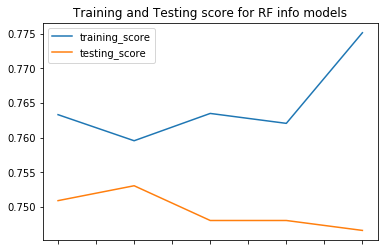

In [119]:
results.loc[['training_score','testing_score'],['RandomForestClassifier_info_1','RandomForestClassifier_info_2','RandomForestClassifier_info_3','RandomForestClassifier_info_4','RandomForestClassifier_info_5']].transpose().plot.line()
plt.title('Training and Testing score for RF info models')
plt.show()

We can above actually see the model is performing better in the training accuracy as we add more variables for each model via polynomial features and removing the amount_invalid feature. It is just that the testing accuracy was reducing, and we can see this is due to overfitting.

**b.5. Discussion on best models and feature importances:**

Now, we check the results for our best models for all 3 and check the feature importances to see the top drivers of effectiveness of offers.

In [120]:
#get best model overall for bogo,discount and info offers
best_model('bogo').append([best_model('discount'),best_model('info')]).transpose()

For bogo RF model:
For discount RF model:
For info RF model:


,RandomForestClassifier_bogo_3,RandomForestClassifier_discount_2,RandomForestClassifier_info_2
pred_time,0.041833,0.039107,0.015864
testing_score,0.828316,0.874656,0.753042
train_time,0.263647,0.258940,0.096562
training_score,0.846882,0.867570,0.759534


Overall, we can see that the top performing models are the 3rd model  for predicting effectiveness of BOGO and discount offers.

In order to find the most influential drivers of an effective offer, we can check the feature importances of our best models above.

##### Show feature importance for BOGO 3 model

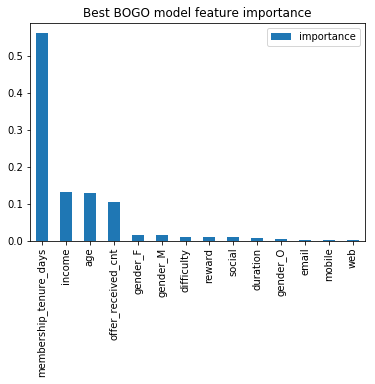

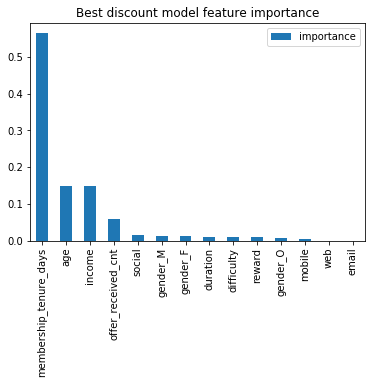

In [121]:
# Prepare data same as BOGO 3 model
drop_cols_prep=['person','offer_id','effective_offer','offer_type','amount_invalid']
features,target=data_prep(offers_bogo,drop_cols_prep)

# Best BOGO model
feature_importances = pd.DataFrame(bogo_3.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Best BOGO model feature importance')
plt.show()

# Discount 3 model
feature_importances = pd.DataFrame(discount_3.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Best discount model feature importance')
plt.show()

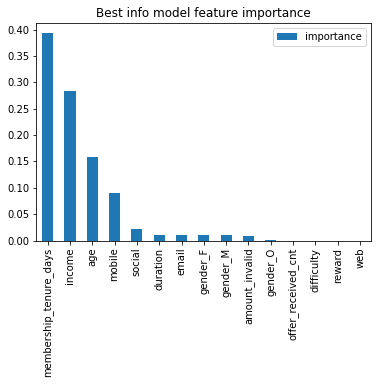

In [122]:

# Prepare data similar to info_2 state
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target=data_prep(offers_discount,drop_cols_prep)

# Show the feature importance
feature_importances = pd.DataFrame(info_2.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Best info model feature importance')
plt.show()

Checking on the feature importance to analyse the main drivers of an effective offer, we can see that the most important driver of effective offers across all three are the tenure of membership. However, the 2nd most important feature is different for each of the three models.

The feature importances for the informational offer models are more distributed compared to the BOGO and discount models, with income being the 2nd most important feature. Age is the third and mobile channel interestingly being the 4th.

### c. Exploration on users in Groups 3 and 4 

We had earlier delineated those in groups 3 and 4 as people who would purchase regardless of viewing any offers. Now we can do some exploratory analyses to see what kind of demographic this group of users consist of.

**c.1. Data Preparation:**

I need to append the data from all groups from the three offer types together, then compare the characteristics of each group via visualizations.

In [123]:
# Perform appending datasets together
# Grp 3+4
grp3_4=grp3_bogo.append(grp3_discount,sort=False)
grp3_4=grp3_4.append(grp3_info,sort=False)
grp3_4=grp3_4.append(grp4_bogo,sort=False)
grp3_4=grp3_4.append(grp4_discount,sort=False)
grp3_4=grp3_4.append(grp4_info,sort=False)

# Grp1
grp1_all=grp1_bogo.append(grp1_discount,sort=False)
grp1_all=grp1_all.append(grp1_info,sort=False)

# Grp2
grp2_all=grp2_bogo.append(grp2_discount,sort=False)
grp2_all=grp2_all.append(grp2_info,sort=False)

In [124]:
# Get unique
grp3_4=grp3_4[['person','offer_id']].groupby(['person','offer_id']).count().reset_index()
grp1_all=grp1_all[['person','offer_id']].groupby(['person','offer_id']).count().reset_index()
grp2_all=grp2_all[['person','offer_id']].groupby(['person','offer_id']).count().reset_index()

# Get membership tenure days
grp3_4=member(grp3_4)
grp1_all=member(grp1_all)
grp2_all=member(grp2_all)

In [125]:
# Merge with transcript to check transaction amount
grp3_4=grp3_4.merge(transcript[['person','offer_id','amount']].groupby(['person','offer_id']).sum(),on=['person','offer_id'],how='left')
grp1_all=grp1_all.merge(transcript[['person','offer_id','amount']].groupby(['person','offer_id']).sum(),on=['person','offer_id'],how='left')
grp2_all=grp2_all.merge(transcript[['person','offer_id','amount']].groupby(['person','offer_id']).sum(),on=['person','offer_id'],how='left')

We should also clean the dataset of null values, similar to the preparation of the datasets above for modeling.

In [126]:
# Check null values and then drop null
print("For grp 3 and 4:")
print((grp3_4.isnull().sum()/len(grp3_4))*100)
grp3_4=grp3_4.dropna()

print("For grp 1:")
print((grp1_all.isnull().sum()/len(grp1_all))*100)
grp1_all=grp1_all.dropna()

print("For grp 2:")
print((grp2_all.isnull().sum()/len(grp2_all))*100)
grp2_all=grp2_all.dropna()

For grp 3 and 4:
person                    0.000000
offer_id                  0.000000
age                       0.000000
gender                    9.019155
income                    9.019155
membership_tenure_days    0.000000
amount                    0.000000
dtype: float64
For grp 1:
person                    0.000000
offer_id                  0.000000
age                       0.000000
gender                    5.896762
income                    5.896762
membership_tenure_days    0.000000
amount                    0.000000
dtype: float64
For grp 2:
person                     0.000000
offer_id                   0.000000
age                        0.000000
gender                    21.131608
income                    21.131608
membership_tenure_days     0.000000
amount                     0.000000
dtype: float64


In [127]:
#check size of groups
print("Size of group 1: "+ str(len(grp1_all['person'])))
print("Size of group 3+4: "+ str(len(grp3_4['person'])))
print("Size of group 2: "+ str(len(grp2_all['person'])))

Size of group 1: 26507
Size of group 3+4: 18904
Size of group 2: 5729


That group 1 is the largest, while group 2 is the smallest, which is unsurprising as we had seen that the classes in our datasets were imbalanced in favour of positive classes (i.e. `effective_offers=1`). 

**c.2. Exploration of demographic characteristics:**

I created a function to efficiently visualize the groups together.

In [128]:
# Define function for multiple histograms
def plot_hist(variable,bins=None):
    plt.hist(grp1_all[variable],alpha=0.5, label='group 1',bins=bins)
    plt.hist(grp3_4[variable], alpha=0.5, label='group 3 and 4',bins=bins)
    plt.hist(grp2_all[variable], alpha=0.5, label='group 2',bins=bins)
    plt.legend(loc='upper right')
    plt.title('The distribution of '+ variable + ' between groups')
    plt.show()

First, we explore the income distribution between the 3 groups.

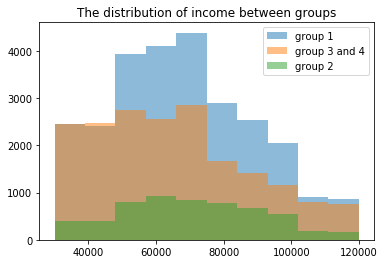

In [129]:
#plot distribution of income
plot_hist('income')

The income distribution between the 3 segments are relatively similar.

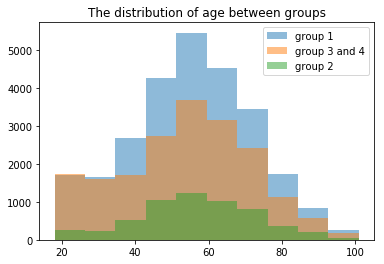

In [130]:
#plot ditribution of age
plot_hist('age')

Age distribution looks relatively similar between the 3 groups as well, with most people between the age 40-80 years old.

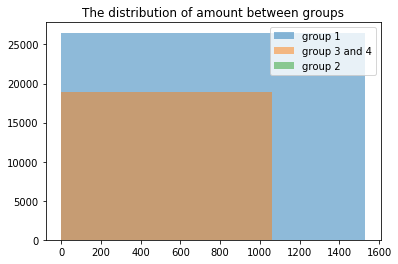

In [131]:
#plot distribution of amount spent given an effective offer
plot_hist('amount',bins=1)

Group 2 are people who did not spend at all as the offers were ineffective on them, hence they are not in the graph. 

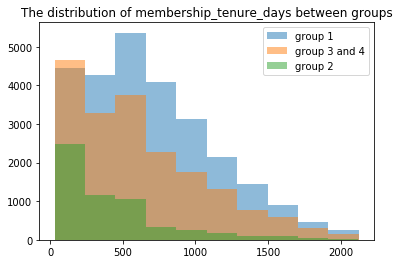

In [132]:
#plot tenure of membership
plot_hist('membership_tenure_days')

The distribution of membership tenure also looks similar between the 3 segments, with most people between 0-700 days of tenure.

### d. Potential all in one model

We could predict the effectiveness of an offer if the offer type was included as a categorical feature.

In [133]:
#append datasets together
offers_bogo['offer_type']='bogo'
offers_info['offer_type']='informational'
offers_discount['offer_type']='discount'
offers=offers_discount.append(offers_bogo,sort=False)
offers=offers.append(offers_info,sort=False)

#create dummy variable for offer_type categorical variable
offers=dummy(offers,'offer_type')

In [134]:
# do grid search to find optimal parameters for RF model
drop_cols_prep=['person','offer_id','effective_offer','amount_invalid']
features,target=data_prep(offers,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

rand_forest_param_selection(X_train, y_train)

{'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 15,
 'min_samples_split': 2,
 'n_estimators': 50}

In [135]:
# Config for test model
drop_cols_prep=['person','offer_id','effective_offer','amount_invalid']
features,target=data_prep(offers,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
all_in_one = RandomForestClassifier(random_state=5,criterion='gini',max_depth= 20, max_features= 'auto',min_samples_split= 2,n_estimators=50,min_samples_leaf=15)

results=pd.concat([results[:],run_model(baseline,all_in_one,'all_in_one')],axis=1)

The DecisionTreeClassifier model is trained for 25594 samples.
The Mean Squared Error Score by train dataset: 0.1761
The Mean Squared Error Score by test datase: 0.1753
The Accuracy Score by train dataset:0.8239
The Accuracy Score by test dataset:0.8247
             precision    recall  f1-score   support

          0     0.5269    0.0778    0.1356      1131
          1     0.8326    0.9850    0.9024      5268

avg / total     0.7786    0.8247    0.7669      6399

The RandomForestClassifier model is trained for 25594 samples.
The Mean Squared Error Score by train dataset: 0.1638
The Mean Squared Error Score by test datase: 0.1749
The Accuracy Score by train dataset:0.8362
The Accuracy Score by test dataset:0.8251
             precision    recall  f1-score   support

          0     0.5316    0.0893    0.1529      1131
          1     0.8341    0.9831    0.9025      5268

avg / total     0.7806    0.8251    0.7700      6399



In [136]:
#comparing best performance of all 3 models with all_in_one model
results[['RandomForestClassifier_bogo_3','RandomForestClassifier_discount_3','RandomForestClassifier_info_2','DecisionTreeClassifier_all_in_one','RandomForestClassifier_all_in_one']]

,RandomForestClassifier_bogo_3,RandomForestClassifier_discount_3,RandomForestClassifier_info_2,DecisionTreeClassifier_all_in_one,RandomForestClassifier_all_in_one
pred_time,0.041833,0.041500,0.015864,0.002386,0.191820
testing_score,0.828316,0.873477,0.753042,0.824660,0.825129
train_time,0.263647,0.256315,0.096562,0.055225,1.095602
training_score,0.846882,0.869044,0.759534,0.823904,0.836212


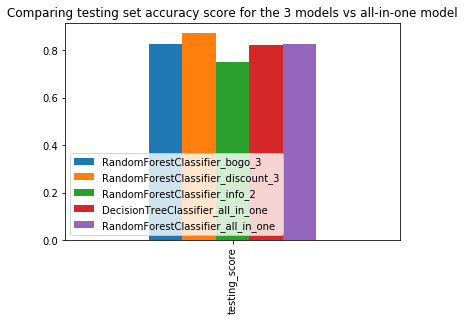

In [137]:
results.loc[['testing_score'],['RandomForestClassifier_bogo_3','RandomForestClassifier_discount_3','RandomForestClassifier_info_2','DecisionTreeClassifier_all_in_one','RandomForestClassifier_all_in_one']].plot.bar()
plt.title('Comparing testing set accuracy score for the 3 models vs all-in-one model')
plt.legend(loc=3)
plt.show()

Comparing the performance of the 3 best models for each offer type with the all_in_one model.

We can se that having the all-in-one model is not as good as the RF bogo and discount models, and is about slightly better than the info model. This is probably due to the info model pulling down the performance, resulting in lower accuracy for the all in one model.

So I would actually suggest that the 3 separate models are more useful.

### e. Given an effective offer

In addition to the all in one model, since we already kept the datasets of effective transactions, I was curious to know if I could build a regression model to predict how much someone would spend, given an effective offer.

So we have already assigned effective offers based on group 1 customers. From there, we just need to sum up their amount of spend driven by offers to see if we can predict how much someone would spend depending on the offer type.

In [138]:
#append all 3 datasets together
grp1=grp1_bogo.append(grp1_discount,sort=False)
grp1=grp1.append(grp1_info,sort=False)

#drop unnecessary columns
drop_cols('effective_offer',grp1,inplace=True)

#get offer details
grp1=grp1.merge(portfolio,how='left',on='offer_id')

We only take into account transactions that are influenced by an offer (i.e. `valid_completed=1`)

In [139]:
#get sum of valid transactions per person based on unique person and offer_id pair
grp1=grp1.merge(transcript[['person','offer_id','amount']][transcript['valid_completed']==1].groupby(['person','offer_id']).sum(),on=['person','offer_id'])

In [140]:
#get demographic data and membership_tenure details
grp1=member(grp1)

#reset index for offers_info
grp1=drop_cols('index',grp1.reset_index())

#reuse offers_info channel_col function to expand channel column into categorical variables
channel_col('web',grp1)
channel_col('email',grp1)
channel_col('mobile',grp1)
channel_col('social',grp1);
drop_cols('channels',grp1,inplace=True);

grp1=prep_offers_df(grp1)

# Encode offer type
grp1=dummy(grp1,'offer_type')

We need to prevent multicollinearity by reducing the level of the dummy variables by 1, dropping those columns.

In [141]:
#add one level of dummy variable to drop
drop_cols_prep=['person', 'offer_id','amount','social','gender_O','offer_type_informational']
target=grp1['amount']
features=drop_cols(drop_cols_prep,grp1)

We need to change the metrics such that it is not a classification model.

I tweak my `train_predict` and `run_model` functions.

In [142]:
#tweak train_predict function -
def train_predict_reg(learner, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - X_train: training set
       - y_train: evaluate the scores rating for the training set
       - X_test: testing set
       - y_test:evaluate the scores rating for the testing set
    
    outputs: The result for the Mean Squared Error and Accuracy Scores
    
    '''
    results = {}
    
    #Fit the learner to the training data and get training time
    start = time() 
    learner = learner.fit(X_train, y_train)
    end = time() 
    results['train_time'] = end-start
    
    # Get predictions on the test set(X_test), then get predictions on first 300 training samples
    start = time() 
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() 
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
    results['training_score']=learner.score(X_train,y_train)
    results['testing_score']=learner.score(X_test,y_test)
    
    print("The {} model is trained for {} samples.".format(learner.__class__.__name__, len(y_train)))
    print("The Mean Squared Error Score by the training dataset: %.4f" % mean_squared_error(y_train,predictions_train))
    print("The Mean Squared Error Score by the testing datase: %.4f" % mean_squared_error(y_test,predictions_test))
    print("The Accuracy Score by the training dataset:%.4f" % results['training_score'])
    print("The Accuracy Score by the testing dataset:%.4f" % results['testing_score'])
    return results

In [143]:
def run_model_reg(clf1,clf2,name):
    '''
    input: clf1: baseline regression model, clf2: 2nd regression model, name: name to keep track
    
    output:
    - dataframe containing results of training and prediction of model
    
    '''
    
    # Collect results
    results = {}
    for clf in [clf1, clf2]:
        clf_name = clf.__class__.__name__ + '_' +name
        results[clf_name] = {}
        results[clf_name]= train_predict_reg(clf, X_train, y_train, X_test, y_test)
        
    return pd.DataFrame(results)

In [144]:
X_train, X_test, y_train, y_test=model_pipeline_poly(features,target,2)

#Initialize the model
clf1 = Ridge(alpha=2,random_state=2)
clf2 = DecisionTreeRegressor(random_state=2)

results_reg=run_model_reg(clf1,clf2,'reg')

The Ridge model is trained for 21011 samples.
The Mean Squared Error Score by the training dataset: 5149.4918
The Mean Squared Error Score by the testing datase: 5264.4857
The Accuracy Score by the training dataset:0.0901
The Accuracy Score by the testing dataset:0.0863
The DecisionTreeRegressor model is trained for 21011 samples.
The Mean Squared Error Score by the training dataset: 0.0410
The Mean Squared Error Score by the testing datase: 11106.1821
The Accuracy Score by the training dataset:1.0000
The Accuracy Score by the testing dataset:-0.9277


In [145]:
# Show result final
results_reg

,Ridge_reg,DecisionTreeRegressor_reg
pred_time,0.098494,0.011639
testing_score,0.086260,-0.927664
train_time,0.241394,1.599488
training_score,0.090122,0.999993


The regression models really underperformed in terms of predicting the amount spent. 

We can see the Decision Tree Regressor model really overfit the data, with a very high training score but sub par testing score.

I may get better performance if I break the models up into 3 different models based on offer type again

## Conclusion

Overall, when analysing and building the machine learning models to answer the above questions, reflections on my main challenges and findings are as follows:

#### Potential current solution discussion

The feature importance given by all 3 models were that the tenure of a member is the biggest predictor of the effectiveness of an offer. Further study would be able to indicate what average tenure days would result in an effective BOGO offer. 

For all three models, the top 3 variables were the same - membership tenure, income and age.
However, the income and age switched orders depending on offer type. 

For BOGO and discount offers, the distribution of feature importances were relatively equal. However, for informational offers, the distribution is slightly more balanced, with income the second most important variable.

We decise using 3 separate models to predict the effectiveness of each offer type ended up with good accuracy for the BOGO and discount models (82.83% for BOGO and 87.35% for discount), while slightly less accurate performance for informational offers (75.3%).
We would regard 75% as acceptable in a business setting, as for informational offers, there is no cost involved to inform users of a product.

-> Meanwhile, for BOGO and discount models, 
We are quite happy with the 80% and above accuracy, as in a business setting that would be acceptable to show offers to people, even if the model misclassifies a few, the overall revenue increase might justify the few mistakes. 


So our our potential solution, when analysing and building the machine learning models to answer the above questions, reflections on my main challenges and findings are as the following:

#### Attribution framework for assigning offer_ids for transactions:

In order to answer Question 1, I had to first define what an 'effective offer' means using the transactional records. This proved to be the trickiest portion of the project. I had to define a funnel for what what an effective conversion would look like, as we had data on both effective and noneffective conversions.

I ended up having to separate the users into 4 different pools, based on their actions in the transcript data:

- Group 1: People who are influenced by offers and thus purchase/complete the offer(successful/effective conversion of offer)
- Group 2: People who receive and an offer but is not influenced and thus no conversion event (ineffective conversion of offer)
- Group 3: People who have conversion events but was not actually influenced by an offer
- Group 4: People who receive offers but no views or action taken

Even after separating the groups, it was challenging to assign the people in group 3 based on the transactional data. I had to 

After attributing the conversions to specific offers, the rest of the data preparation and cleaning was relatively straightforward. 

####  Feature engineering:

I decided to do some basic feature engineering as I found the model had slightly underfit on my first attempt in this project, so I had added the feature engineering section later.

Overall I found that I could not think of additional features using the time data, even though I had the hunch that the time of receiving the offer might be quite influential in determining whether it is effective or not. 

#### Model implementation decisions:

For the info model, the accuracy was slightly worse as we had less records overall (half of the BOGO and discount models).

I believe that if we had more data, I could have gotten the accuracy higher, as there was a clear diverging pattern occurring between the training and testing score as I made decisions to improve the model fit like adding polynomial features and removing 'noisy' features like the amount_invalid feature.

An additional note on model selection - I selected tree-based models as I wanted to assess feature importance, but I could have extended this study further by testing a parametric/ regression model (e.g. logistic regression for classification tasks). The feature `membership_tenure_days` might not have been the highest weighted feature, in contrast to how it was in this study.

#### Exploring demographics of different customer groups:

I was curious to know what the characteristics were of groups 3 and 4, which are customers who are not influenced by an offer at all.

I would have liked to have more data to perhaps understand why this group of customers tend to not be influenced by offer, in order to make useful suggestions on how to give a good customer experience to these customers, even if we do not serve them any offers.

#### Model accuracy in predicting amount spent given an effective offer

The regression model I built out of curiosity to see if we could predict the amount a user would spend, given that they are effectively influenced by an offer. 

The motivation was that if we can predict how much someone would spend given an offer, perhaps we can assess which offers bring in the most revenue. 

My model found virtually no correlation between the features provided (namely, offer characteristics and demographics of app users) with the amount spent per user. 

So I could have broken them up into 3 different models for the 3 offer types, the way I did with the binary classification models, in order to get a better result. However, given that this was just a curiosity and I wanted to explore if the offer type would be a statistically significant predictor feature. 

In addition, I built an all in one model for this instance. This would be worth exploring further, given more time and data.